In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
from xopt import Xopt

# set values if testing
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")

YAML = """
generator:
    name: bayesian_exploration

evaluator:
    function: xopt.resources.test_functions.tnk.evaluate_TNK

vocs:
    variables:
        x1: [0, 3.14159]
        x2: [0, 3.14159]
    observables: [y1]
    constraints:
        c1: [GREATER_THAN, 0]
        c2: [LESS_THAN, 0.5]
    constants: {a: dummy_constant}

"""

In [2]:
X = Xopt.from_yaml(YAML)

# for testing purposes only
if SMOKE_TEST:
    X.generator.numerical_optimizer.n_restarts = 1
    X.generator.n_monte_carlo_samples = 1

X


            Xopt
________________________________
Version: 0+untagged.1266.gb391bbe.dirty
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    use_low_noise_prior: true
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_monte_carlo_samples: 128
  name: bayesian_exploration
  numerical_optimizer:
    max_iter: 2000
    n_restarts: 20
    name: LBFGS
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants:
    a: dummy_constant
  constraints:
    c1:
    - GREATER_THAN
    - 0.0
    c2:
    - LESS_THAN
    - 0.5
  objectives:
    y1: MINIMIZE
  ob

In [3]:
X.random_evaluate(5)

for i in range(5):
    print(f"step {i}")
    X.step()

step 0
step 1
step 2
step 3
step 4


In [4]:
print(X.data)

          x1        x2               a        y1        y2         c1  \
0   2.993476  1.092411  dummy_constant  2.993476  1.092411   9.076792   
1   1.169031  1.117434  dummy_constant  1.169031  1.117434   1.521738   
2   2.862666  2.549712  dummy_constant  2.862666  2.549712  13.635635   
3   2.151784  0.052872  dummy_constant  2.151784  0.052872   3.540597   
4   1.292425  2.416395  dummy_constant  1.292425  2.416395   6.509756   
6   0.000000  1.456950             NaN  0.000000  1.456950   1.022702   
7   0.238050  0.000000             NaN  0.238050  0.000000  -1.043332   
8   0.671759  1.206354             NaN  0.671759  1.206354   0.933746   
9   1.190292  0.244689             NaN  1.190292  0.244689   0.576143   
10  0.906943  0.760457             NaN  0.906943  0.760457   0.384045   

          c2  xopt_runtime  xopt_error  
0   6.568374      0.000022       False  
1   0.828827      0.000007       False  
2   9.783511      0.000006       False  
3   2.928315      0.000006      

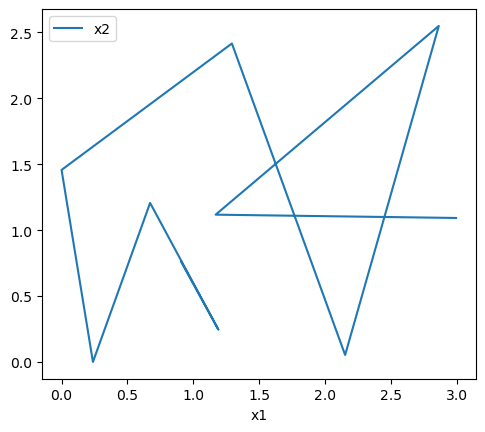

In [5]:
# plot results
ax = X.data.plot("x1", "x2")
ax.set_aspect("equal")

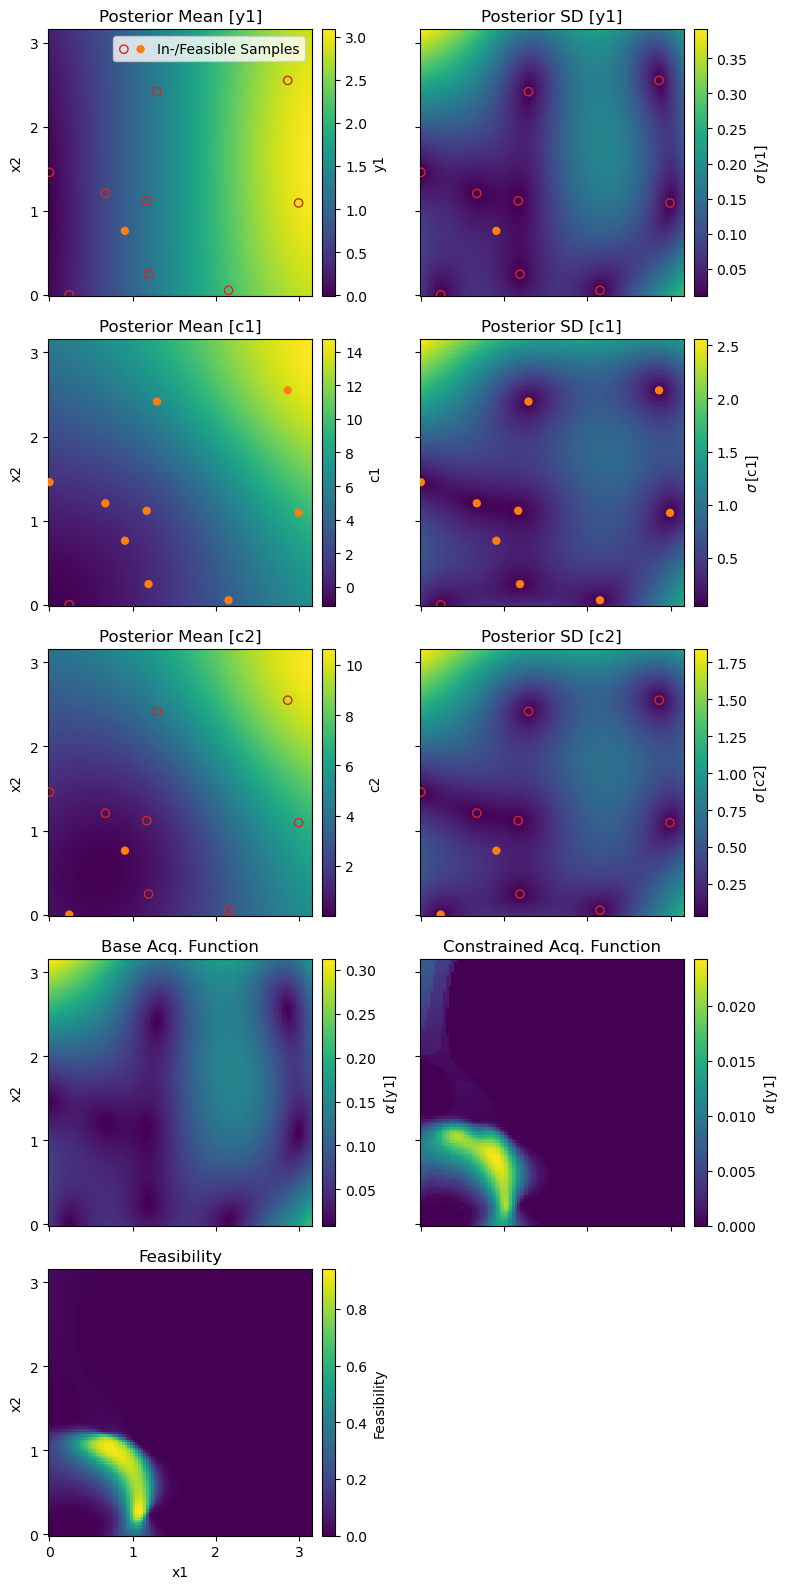

In [6]:
fig, ax = X.generator.visualize_model(show_feasibility=True, n_grid=100)